In [24]:
# External imports
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
import corner
import seaborn as sns
#sns.set_theme()
import arviz as az

import emcee

# Set plot params
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

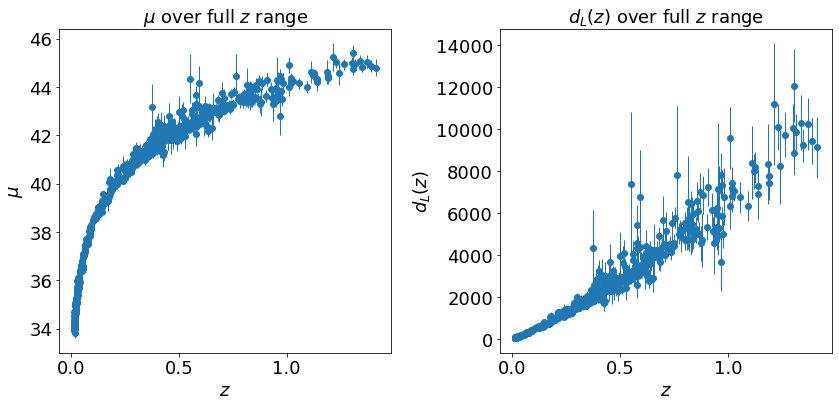

In [5]:
### Imported data
z = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 1)
mu = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 2)
delta_mu = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 3)
data4 = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 4)

### Sort data for increasing z
sortOrder = np.argsort(z)
z = z[sortOrder]
mu = mu[sortOrder]
delta_mu = delta_mu[sortOrder]
dl = 10**(mu/5-5) # Extract dl(z) from modulus
delta_dl = dl*np.log(10)*delta_mu/5

### Plot the data
fig,ax = plt.subplots(1,2, figsize = (12,6))
ax[0].scatter(z,mu)
ax[0].errorbar(z,mu,delta_mu, linewidth = 0, elinewidth = 1)
ax[0].set_title(r'$\mu$ over full $z$ range')
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$\mu$')


ax[1].scatter(z,dl)
ax[1].errorbar(z,dl,delta_dl, linewidth = 0, elinewidth = 1)

ax[1].set_title(r'$d_L(z)$ over full $z$ range')
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$d_L(z)$')

plt.tight_layout()

#### Define models

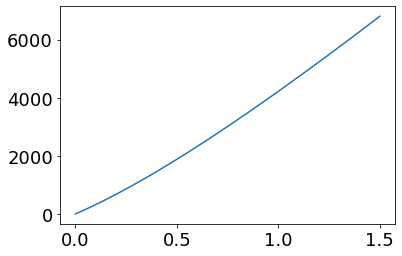

In [70]:
c = 299792458
H0 = 70000
def lambda_CDM(z, Omega_M, Omega_Lambda):
    dl_z = np.zeros(len(z))
    for i, zi in enumerate(z):
        z_prim = np.linspace(0, zi, 100)
        Ez_prim = Omega_M * (1+z_prim)**3 + Omega_Lambda
        Hz_prim = H0 * np.sqrt(Ez_prim)
        dl_z[i] = c*(1+zi) * np.trapz(y=1/Hz_prim, x=z_prim)
    return dl_z

def omega_CDM(z, Omega_M, Omega_Lambda, omega):
    dl_z = np.zeros(len(z))
    for i, zi in enumerate(z):
        z_prim = np.linspace(0, zi, 100)
        Ez_prim = Omega_M * (1+z_prim)**3 + Omega_Lambda*(1+z_prim)**(3*(1+omega))
        Hz_prim = H0 * np.sqrt(Ez_prim)
        dl_z[i] = c*(1+zi) * np.trapz(y=1/Hz_prim, x=z_prim)
    return dl_z

z_test = np.linspace(0,1.5)
dl_test = lambda_CDM(z_test, 1,1)
plt.plot(z_test, dl_test)

#### Emcee setup

In [59]:
# Priors

# ej normalizerade

def log_prior(theta):
    Omega_M, Omega_lambda = theta
    if 0.0 < Omega_M < 1 and 0.0 < Omega_lambda < 1.0:
        return 0.0
    return -np.inf

def log_lambda_likelihood(theta, z, dl, dl_err):
    # Use data weights equal to the measurement variance - i.e. set scale to 1 (known)
    W = np.diag(dl_err**(-2))
    # TODO Return logarithm of multivariate normal distribution
    Omega_M, Omega_lambda = theta
    dl_z = lambda_CDM(z, Omega_M, Omega_lambda)
    #p = -(dl-dl_z)@W@(dl-dl_z)/2
    #p  = -0.5*np.sum(((dl-dl_z)/dl_err)**2)
    #print(dl_z)
    return -0.5*(dl-dl_z)@W@(dl-dl_z)

def log_omega_likelihood(theta, z, dl, dl_err, w=1):
    # Use data weights equal to the measurement variance - i.e. set scale to 1 (known)
    W = np.diag(dl_err**(-2))
    # TODO Return logarithm of multivariate normal distribution
    Omega_M, Omega_lambda = theta
    dl_z = omega_CDM(z, Omega_M, Omega_lambda, w) 
    p = -(dl-dl_z)@W@(dl-dl_z)/2
    print(p)
    return p

def log_lambda_posterior(theta, z, dl, dl_err):
    return log_lambda_likelihood(theta, z, dl, dl_err) + log_prior(theta)

def log_omega_posterior(theta, z, dl, dl_err, w=1):
    return log_omega_likelihood(theta, z, dl, dl_err, w) + log_prior(theta)



In [77]:
def minus_log_lik(theta, z, dl, dl_err):
    return -log_lambda_likelihood(theta, z, dl, dl_err)
nll = lambda *args: -log_lambda_likelihood(*args)

theta_hat = sc.optimize.minimize(minus_log_lik, [0.5,0.5], args=(z, dl, delta_dl), bounds = ((1e-5,10),(1e-5,10)))
print(theta_hat)


      fun: 269.9427391068333
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00042064, 0.00021032])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 9
   status: 0
  success: True
        x: array([0.30012495, 0.71083723])


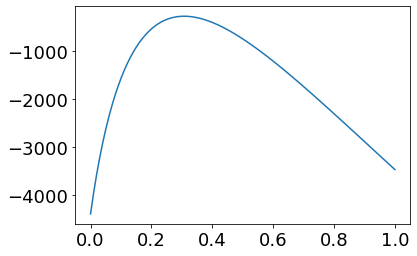

In [78]:
Omega = np.linspace(0,1,100)
theta = np.zeros(len(Omega))
for i, w in enumerate(Omega):
    theta[i] = log_lambda_likelihood((w,0.7), z, dl,delta_dl)
plt.plot(Omega,theta)

In [82]:
bic = -2*theta_hat.fun - (2)*np.log(len(z))
print(bic)

aic = -2*theta_hat.fun - 2*2
print(aic)

-552.6115344207475
-543.8854782136666
